# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *
from paths_and_parameters import *

paths_to_create_delete = [subfolder_output, path_figures, path_results]

distance_merge = sigma   # Distance under which peaks are merged in each phase. Put None to avoid merging.

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database/'
Total number of phases: 369


# Read XRD data
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [18]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

data.rotate(steps_rotation_xrd)
y_x_ratio = data.shape[0] / data.shape[1]
print('\nShape of data\n-------------')
print(f'x: {data.shape[1]}, y: {data.shape[0]}, channels: {data.shape[2]}')
print('\nInitial calibration\n-------------------')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range: {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5

Shape of data
-------------
x: 170, y: 95, channels: 1280

Initial calibration
-------------------
a = -1214.7, s = 1952.7, beta = 51.663
Theta range: [19.77907407899562, 53.578190550653794]


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [19]:
qtl = 0.997

data.correct_quantile_pixels(qtl)

49 pixels out of 16150 were corrected.


# Read XRF element maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [20]:
data_xrf_elements = DataXRF().read_tiff(path_xrf_elements).flip(axis = xrf_axes_flip).rotate(steps_rotation_xrf_elements)
y_x_ratio = data_xrf_elements.labels.shape[0] / data_xrf_elements.labels.shape[1]
print(f'Found {data_xrf_elements.labels.shape[2]} images: ' + ', '.join([name for name in data_xrf_elements.metadata['labels']]))
print('\nShape of XRF element maps\n-------------------------')
print(f'x: {data_xrf_elements.labels.shape[1]}, y: {data_xrf_elements.labels.shape[0]}')

Found 24 images: Al_K, Ar_K, As_K, Ba_L, Ca_K, Cd_L, Cl_K, Co_K, Cr_K, Cu_Ka, Cu_Kb, Fe_K, Hg_L, K_K, Mn_K, P_K, Pb_L, Pb_M, S_K, Se_K, Si_K, Sn_L, Ti_K, Zn_K

Shape of XRF element maps
-------------------------
x: 170, y: 95


### Correct burnt pixels and wrong scale in each element map; also calculate normalized element maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [21]:
#qtl = 0.999

#data_xrf_elements.map_correct_specific_pixels([(0, 0)])
data_xrf_elements.map_correct_quantile_pixels(qtl).map_correct_scale()

maps_xrf_norm = data_xrf_elements.labels / data_xrf_elements.labels.max(axis = (0, 1), keepdims = True)

49 pixels out of 16150 were corrected on average in each XRF map.


# Select area

### Show phases with given elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [22]:
elements_chosen = ['Pb']
elements_excluded = []
# DO NOT EXCLUDE: Al, Ca, Cl, P, S, Si

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,(Pb O) (Pb (Cr O4)),Cr O5 Pb2,1
1,Anglesite,O4 Pb S,5
2,Cerussite,C O3 Pb,6
3,Crocoite,Cr O4 Pb,3
4,Hydrocerussite,C2 H2 O8 Pb3,2
5,Lead,Pb,5
6,Lead Chromate Oxide,Cr O5 Pb2,1
7,Lead-tin yellow,Pb2 Sn O4,1
8,Litharge,O Pb,12
9,Massicot,O Pb,1


### Show area given by XRF threshold
- `threshold_XRF_intensity`: The routine selects pixels where the first of `elements_chosen` has an XRF intensity above this threshold value.

Element chosen for the map of XRF intensity: Pb_L
Threshold: 0.5
Selected pixels: 15564


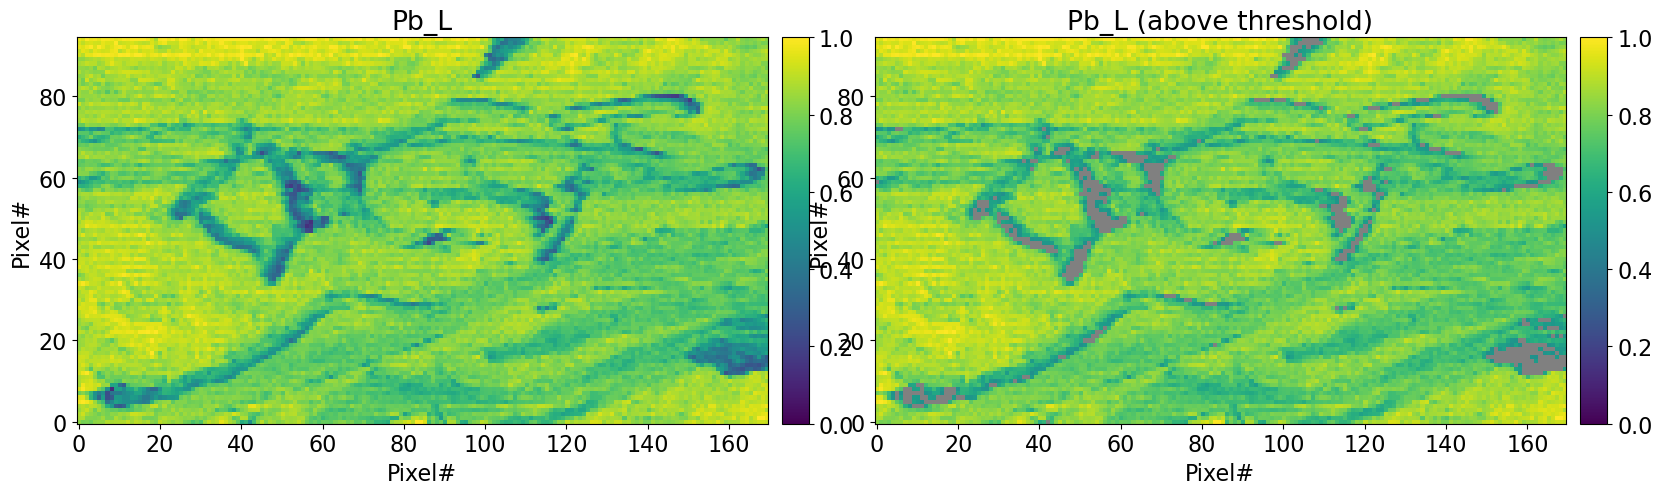

In [23]:
rcParams['font.size'] = 16

threshold_XRF_intensity = 0.5

###

idx_element_threshold = find_element(elements_chosen[0], data_xrf_elements.metadata['labels'])
print('Element chosen for the map of XRF intensity: ' + data_xrf_elements.metadata['labels'][idx_element_threshold])
print(f'Threshold: {threshold_XRF_intensity}')

indices_XRF_sel = zeros(data_xrf_elements.labels.shape[:2], bool)
for x in range(data_xrf_elements.labels.shape[1]):
    for y in range(data_xrf_elements.labels.shape[0]):
        if maps_xrf_norm[y, x, idx_element_threshold] >= threshold_XRF_intensity:
            indices_XRF_sel[y, x] = True
print(f'Selected pixels: {indices_XRF_sel.sum()}')

map_for_search = maps_xrf_norm[..., idx_element_threshold].copy()
map_for_search[~indices_XRF_sel] = nan

fig, axs = subplots(1, 2, figsize = (16, 6))
fig.tight_layout(w_pad = 2)
cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')

ax = axs[0]
im = ax.imshow(maps_xrf_norm[..., idx_element_threshold], interpolation = 'none', vmin = 0, vmax = 1)
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element_threshold])

ax = axs[1]
im = ax.imshow(map_for_search, interpolation = 'none', vmin = 0, vmax = 1, cmap = cmap_viridis)
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element_threshold] + ' (above threshold)')

show()

### Select area: 3 options

In [24]:
# All the area of the scan
indices_sel = ones(data.shape[:2], bool)

In [12]:
# Only pixels where XRF intensity is above threshold
indices_sel = indices_XRF_sel

In [11]:
# Rectangular subset of the scan
x_min, x_max = 90, 139
y_min, y_max = 20, 69
indices_sel = zeros(data.shape[:2], bool)
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if ((x >= x_min) and (x <= x_max) and (y >= y_min) and (y <= y_max)):
            indices_sel[y, x] = True

# Select primary phases

### Manually select phases

In [25]:
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
lazurite = database['Lazurite'][0]

phases_primary = [hydrocerussite, cinnabar, lazurite]

In [14]:
hydrocerussite = database['Hydrocerussite'][0].select_peaks([]) #[i for i in range(15) if i != 3]
gold = database['Gold'][10].select_peaks([])
cinnabar = database['Cinnabar'][1].select_peaks([])
lead_tin_y = database['Lead-tin yellow'][0].select_peaks([])

phases_primary = [hydrocerussite, gold, cinnabar, lead_tin_y]

### Take phases from file `phases_selection_primary.dat`

In [17]:
phases_primary = phases_from_file(subfolder_output + 'phases_selection_primary.dat', database)

Loaded phases: Ca Cu Si4 O10 0, Copper silicate 0, Cuprorivaite 0


### Set parameters of synthetic XRD patterns
You can skip this cell and keep the preset values of the parameters.

### Check the number of tabulated peaks given by chosen parameters

In [13]:
#### Se non sceglo picchi mi segna un numero se scelgo picchi numero non congruente. Ad es huntite 7 picchi, se scelgo i pimi 5 la tabella dice 2 picchi
# Questo succede perché 3 dei primi 5 picchi stanno fuori dall'intervallo angolare scelto.
# Al momento la scelta dei picchi è implementata cosí:
# - ogni picco ha un indice assegnato da 0 a n, in ordine d'intensità, considerando tutti i picchi senza limitare l'intevallo angolare.
# - min_theta e max_theta selezionano in base all'angolo.
# - min_intensity seleziona in base all'intensità.
# - first_n_peaks seleziona solo quei picchi il cui indice è minore del valore scelto

In [26]:
#min_intensity = None
#first_n_peaks = None
distance_merge = sigma

In [27]:
df_phases = DataFrame(columns = ['Phase', 'N. of selected peaks'])
for i, p in enumerate(phases_primary):
    df_phases.loc[i] = [p.label, len(p.get_theta(min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)[0])]
df_phases

,Phase,N. of selected peaks
0,Hydrocerussite,4
1,Cinnabar,4
2,Lazurite,4


# Search for primary phases

### Process experimental XRD pattern

In [39]:
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 15  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 1          # degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

data = data.remove_background(window_snip = window_snip, offset_background = offset_background).smooth_channels(std_smooth)

Removing background...
Done.
Smoothing along channels...
Done.


### Change initial calibration

In [27]:
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [40]:
%%time

phase_presence_method = 'adjustment_ratio'
# 'overlap_area', 'overlap_area_ratio', 'adjustment_ratio'

gm = GammaMap().from_data(data, phases_primary, indices_sel, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
gm = gm.search(method = phase_presence_method)

Using 8 CPUs


exception calling callback for <Future at 0x2d96f7f10 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/dariozappala/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/dariozappala/miniconda3/lib/python3.10/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/Users/dariozappala/miniconda3/lib/python3.10/site-packages/joblib/parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/dariozappala/miniconda3/lib/python3.10/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/dariozappala/miniconda3/lib/python3.10/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/dariozappala/miniconda3/lib/python3.10/site-packages/joblib/_pa

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11)}

#### Fast mapping

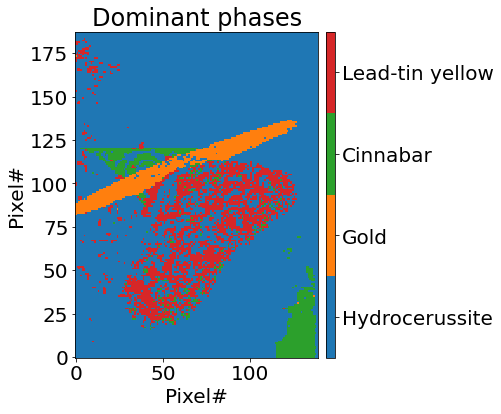

In [19]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = ax.imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

### Inspect pixel

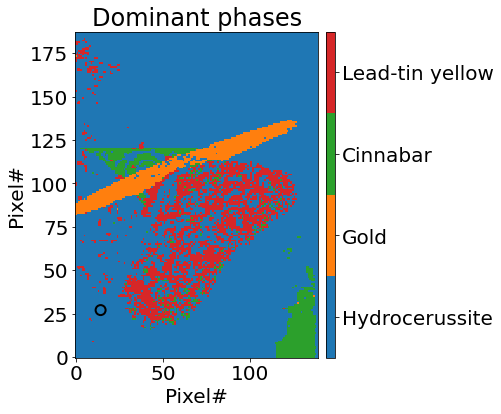

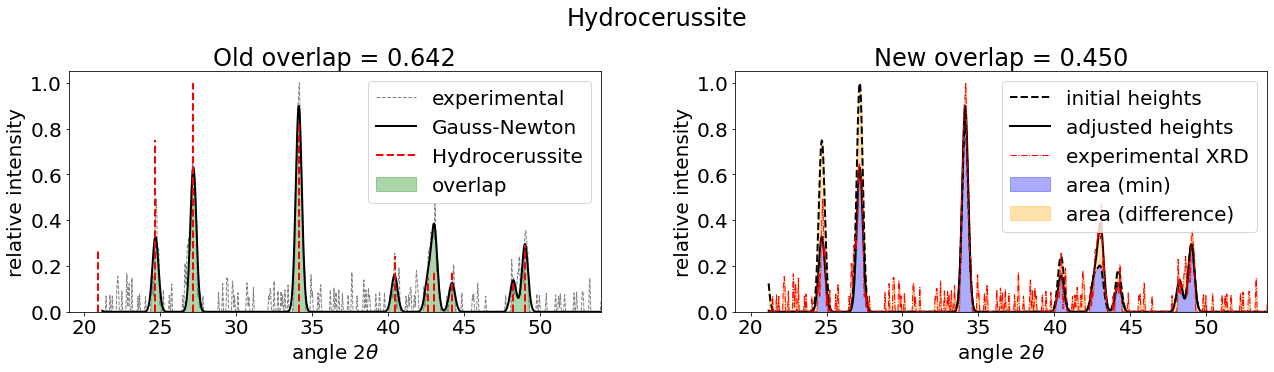

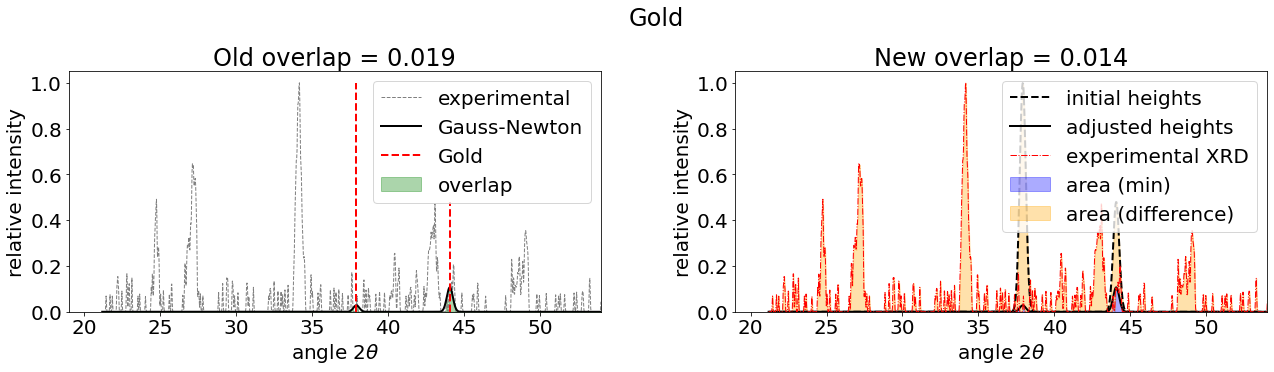

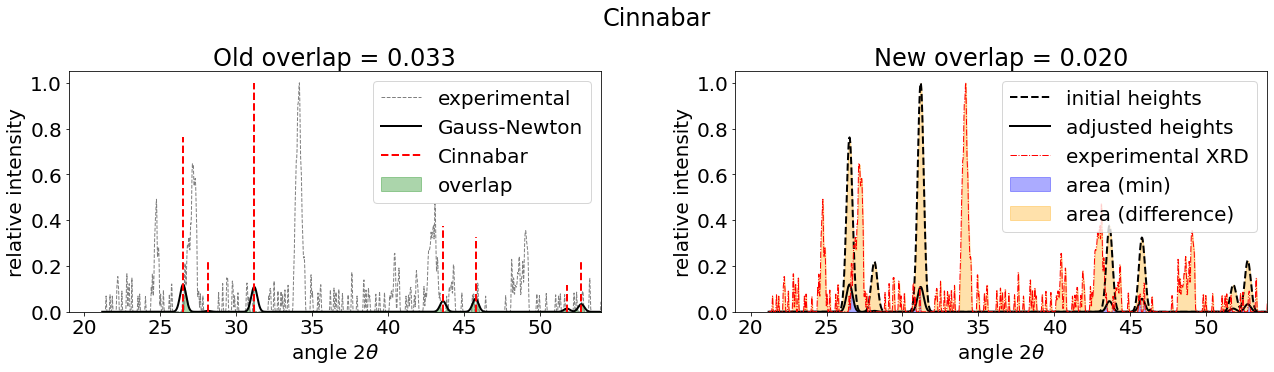

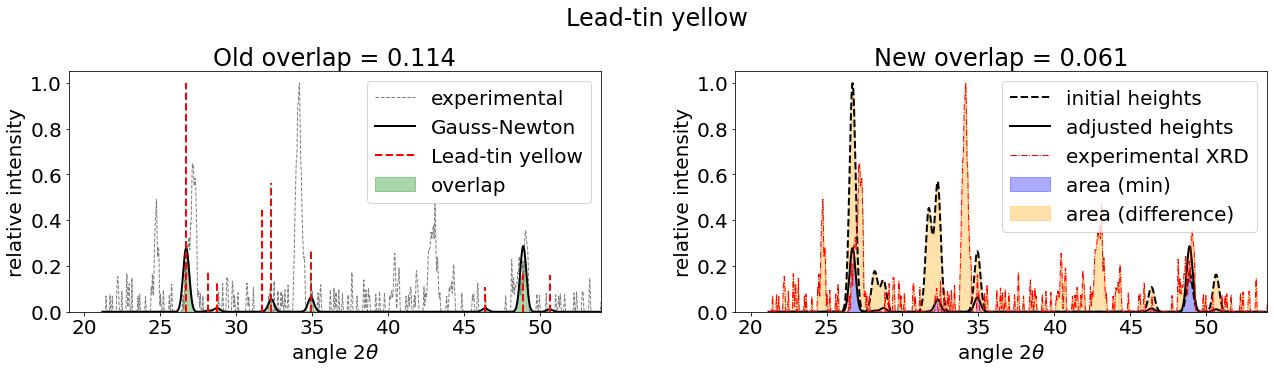

In [20]:
rcParams['font.size'] = 20
x, y = 14, 27

###

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = ax.imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

gs = gm.get_pixel(x, y)

for i in range(len(gs)):
    gn = gs[i]
    
    z0 = clip(gn.z0(), None, 1)
    z = clip(gn.z(), None, 1)
    z_stack = stack((z0, z, gn.intensity))
    z_min = z_stack.min(axis = 0)
    z_max = z_stack.max(axis = 0)
    overlap = z_min.sum() / z_max.sum()

    fig, axs = subplots(1, 2, figsize = (18, 5))
    fig.tight_layout(w_pad = 4)
    fig.subplots_adjust(top = 0.8)   # To shift the title
    
    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.plot_phase(lw = 2, alpha = 1)#, label = 'tabulated peaks')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Old overlap = {gn.overlap_area_ratio():.3f}')
    
    ax = axs[1]
    ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
    ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
    ax.plot(gn.theta, gn.intensity, c = 'red', ls = '-.', lw = 1, label = 'experimental XRD')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (difference)')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'New overlap = {gn.adjustment_ratio():.3f}')
    
    fig.suptitle(gn.phase.label)
    
    savefig(f'{path_figures}{clean_phase_name(gn.label)} - check fit.png', bbox_inches = 'tight', dpi = 300)
    show()
    close(fig)

# Quantify phase presence

Here we choose the method to quantify phase presence

In [21]:
%%time

phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True)           # vecchio metodo
# ('overlap_area_ratio', False)    # vecchio metodo, altro modo di realizzarlo
# ('adjustment_ratio', False)      # nuovo metodo

phase_presence = gm.phase_presence(method = phase_presence_method, correction = phase_presence_correction)

Using 8 CPUs
CPU times: user 7.26 s, sys: 987 ms, total: 8.25 s
Wall time: 9.3 s


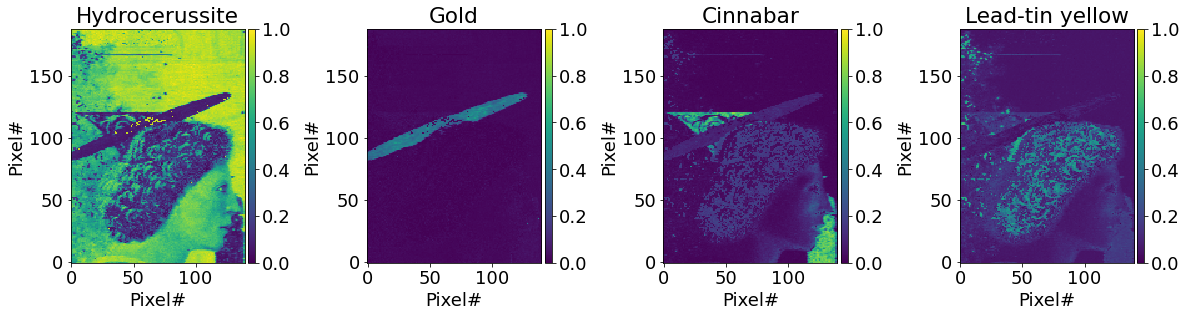

In [22]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

set_nan_as_0 = False

###

matrix_plot = phase_presence / nanmax(phase_presence)
#matrix_plot = phase_presence / nanmax(phase_presence, axis = (0, 1), keepdims = True)
if set_nan_as_0:
    matrix_plot[isnan(matrix_plot)] = 0

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 5 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 4)
cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]

    im = ax.imshow(matrix_plot[..., i], interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_title(phase.label)
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')

show()

### Save maps as PNG and TIF

In [60]:
matrix_plot = phase_presence / nanmax(phase_presence)
#matrix_plot = phase_presence / nanmax(phase_presence, axis = (0, 1), keepdims = True)
matrix_plot[isnan(matrix_plot)] = 0
matrix_tiff = flip((matrix_plot * 65535).astype('uint16'), axis = [0])

for i, phase in enumerate(gm.phases):
    fig, ax = subplots(figsize = (5, 3))
    im = imshow(matrix_plot[..., i], interpolation = 'none', vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(phase.label)
    fig.set_dpi(80)
    savefig(path_figures + 'primary - ' + phase.label + ' - presence.png',
                bbox_inches = 'tight', dpi = 600)

    img = Image.fromarray(matrix_tiff[..., i])
    img.save(path_results + 'primary - ' + phase.label + ' - presence BW.tiff')
    img.save(path_figures + 'primary - ' + phase.label + ' - presence BW.png')

    close(fig)

# Explore one pixel with fitted primary phases
- You can select phases that have all the given elements
- The pixel to analyse can be selected manually, or automatically from XRF map, or automatically from phase presence

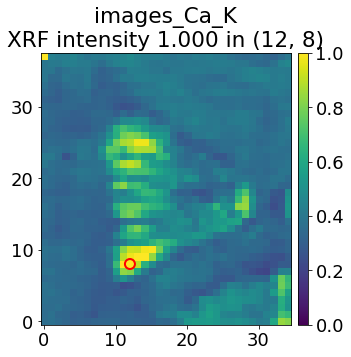

,XRF element,XRF intensity,Phase,Old overlap,New overlap,Normalised presence,"(x, y)"
0,images_Ca_K,1.000,Huntite,0.821,0.610,1.000,"(12, 8)"
1,images_Ca_K,1.000,Cuprorivaite,0.038,0.008,0.012,"(12, 8)"


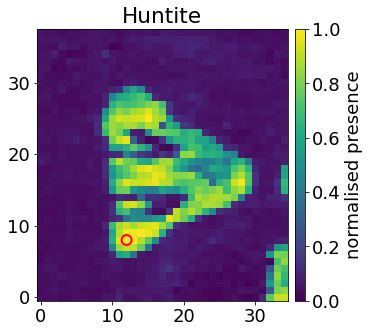

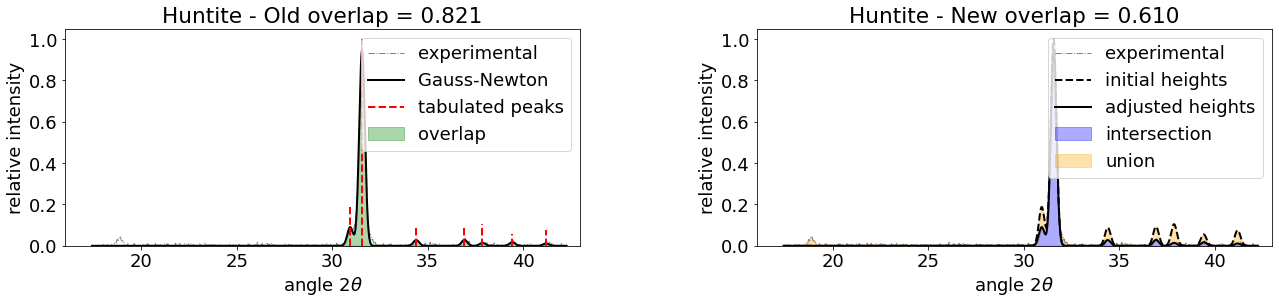

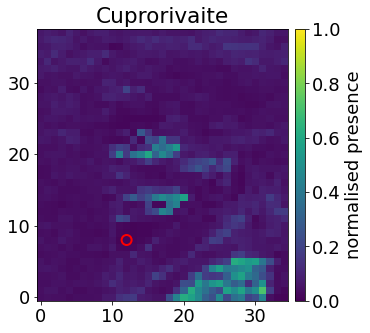

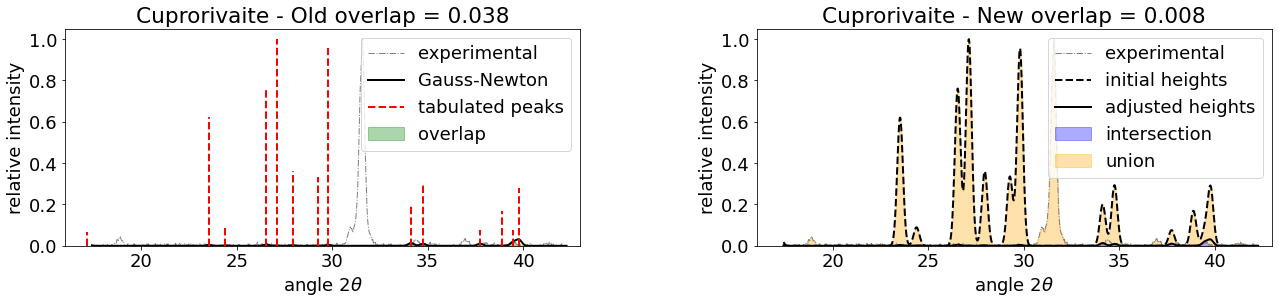

In [61]:
from numpy import nan

rcParams['font.size'] = 18

elements_chosen = ['Ca'] # Only phases with these elements will be selected

#selection_of_x_y = 'manual'               # Manually select the pixel
selection_of_x_y = 'from XRF'             # Automatically select the pixel in which the first element chosen has maximum XRF intensity
#selection_of_x_y = 'from phase presence'  # Automatically select for each phase the pixel in which the phase has maximum presence

n_th_best_pixel = 0

x, y = 20, 30

###

def get_nth_best_pixel(map_pixels, gm, n):
    map_pixels_flattened = gm.format_as_1d_from_2d(map_pixels)
    indices_sorted = map_pixels_flattened.argsort()
    indices_sorted_clean = indices_sorted[: (~isnan(map_pixels_flattened)).sum()]
    position = flip(indices_sorted_clean)[n]
    return gm.get_x_y(position)

cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')

selection_phases = zeros(len(gm.phases), dtype = bool)
for i, phase in enumerate(gm.phases):
    if '_chemical_formula_sum' in phase:
        if all(e in phase['_chemical_formula_sum'] for e in elements_chosen):
            selection_phases[i] = True

i_element = find_element(elements_chosen[0], data_xrf_elements.metadata['labels'])
if i_element is None:
    print(f'Could not find element \'{elements_chosen[0]}\' among XRF element images.')
else:
    map_xrf = maps_xrf_norm[..., i_element]
    #maps_phase_presence = phase_presence / nanmax(phase_presence, axis = (0, 1), keepdims = True)
    maps_phase_presence = phase_presence / nanmax(phase_presence)

    df_stats = DataFrame(columns = ['XRF element', 'XRF intensity', 'Phase', 'Old overlap', 'New overlap', 'Normalised presence', '(x, y)'])

    if selection_of_x_y == 'from XRF':
        x, y = get_nth_best_pixel(map_xrf, gm, n_th_best_pixel)
        
        map_xrf_restricted = map_xrf.copy()
        map_xrf_restricted[~gm.indices_sel] = nan
        fig, ax = subplots(figsize = (10, 5))
        im = ax.imshow(map_xrf_restricted, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
        cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
        ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
        ax.set_title(data_xrf_elements.metadata['labels'][i_element] + f'\nXRF intensity {map_xrf[y, x]:.3f} in {(x, y)}')
        show()

    if (selection_phases.sum() > 0):
        j = 0
        for i, phase in enumerate(gm.phases):
            if selection_phases[i]:
                if selection_of_x_y == 'from phase presence':
                    x, y = get_nth_best_pixel(maps_phase_presence[..., i], gm, n_th_best_pixel)
                gn = gm.get_pixel(x, y)[i]
                
                fig, ax = subplots(figsize = (10, 5))
                im = ax.imshow(maps_phase_presence[..., i], interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
                cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
                cbar.set_label('normalised presence')
                ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
                ax.set_title(phase.label)
                
                z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
                z = clip(gn.z(), None, 1)
                intensity_corrected = maximum(gn.intensity, 0)
                z_stack = stack((z0, z, intensity_corrected))
                z_min = z_stack.min(axis = 0)
                z_max = z_stack.max(axis = 0)
                presence = z_min.sum() / z_max.sum()
                
                fig, axs = subplots(1, 2, figsize = (18, 4))
                fig.tight_layout(h_pad = 5, w_pad = 7)

                ax = axs[0]
                sca(ax)
                gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
                gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
                gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
                ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
                ax.legend(frameon = True, loc = 'upper right')
                ax.set_xlim(min_theta - 1, max_theta + 1)
                ax.set_ylim(0, 1.05)
                ax.set_xlabel(r'angle $2\theta$')
                ax.set_ylabel(r'relative intensity')
                ax.set_title(f'{phase.label} - Old overlap = {gn.overlap_area_ratio():.3f}')

                ax = axs[1]
                sca(ax)
                gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
                ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
                ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
                ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'intersection')
                ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'union')
                ax.legend(frameon = True, loc = 'upper right')
                ax.set_xlim(min_theta - 1, max_theta + 1)
                ax.set_ylim(0, 1.05)
                ax.set_xlabel(r'angle $2\theta$')
                ax.set_ylabel('relative intensity')
                ax.set_title(f'{phase.label} - New overlap = {gn.adjustment_ratio():.3f}')
                
                df_stats.loc[len(df_stats)] = [
                    data_xrf_elements.metadata['labels'][i_element], map_xrf[y, x], phase.label,
                    gn.overlap_area_ratio(), gn.adjustment_ratio(), maps_phase_presence[y, x, i], (x, y)
                ]
                j += 1

    display(df_stats.style.format({'XRF intensity': '{:.3f}', 'Old overlap': '{:.3f}', 'New overlap': '{:.3f}', 'Normalised presence': '{:.3f}'}))
    show()

# Select secondary phases

### Manually select them

In [62]:
#S1 = database['Metacinnabar'][1]
#S2 = database['Metahalloysite'][0]
#S3 = database['Sodalite'][20]
#S4 = database['Barite'][0]
#S5 = database['Goethite'][15]
#S6 = database['Hematite'][9]
#S7 = database['Hematite'][0]

#S1 = database['Bone_Black'][0]
S2 = database['Goethite'][0]
S3 = database['Hematite'][4]

phases_secondary = [S2, S3]

### Take them from file `phases_selection_secondary.dat`

In [24]:
phases_secondary = phases_from_file(subfolder_output + 'phases_selection_secondary.dat', database)

Loaded phases: Crocoite 2


# Search for secondary phases

### Set parameters of synthetic phases
You can skip this cell and keep the preset values of the parameters.

In [63]:
#min_intensity = 0.05  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks_secondary = None   # selects the first n most intense peaks (if None, leaves all the peaks)

### Check the number of tabulated peaks given by chosen parameters

In [64]:
df_phases = DataFrame(columns = ['Phase', 'N. of selected peaks'])
for i, p in enumerate(phases_secondary):
    df_phases.loc[i] = [p.label, len(p.get_theta(min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks_secondary, distance_merge = distance_merge)[0])]
df_phases

,Phase,N. of selected peaks
0,Goethite,9
1,Hematite,4


### Smooth data along pixels

In [65]:
step = 2
method = 'mean'
#method = 'max'

data_smooth = (
    data
    .generate_spatial_smooth(step, method)
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_smooth)
)

Generating smooth data...
Done.
Removing background...
Done.
Smoothing along channels...
Done.


### Refit primary phases on smoothed data

In [66]:
%%time

gm1 = GammaMap().from_data(data_smooth, phases_primary, indices_sel, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
gm1 = gm1.search(method = phase_presence_method)

Using 8 CPUs
CPU times: user 1.87 s, sys: 165 ms, total: 2.04 s
Wall time: 4.65 s


### Fit secondary phases on smoothed data

You can choose how many peaks to consider in secondary phases

In [67]:
%%time

gm2 = GammaMap_Secondary().from_data(gm1, phases_secondary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
gm2 = gm2.fit_cycle(steps = 6, gamma = True)

Using 8 CPUs
CPU times: user 913 ms, sys: 135 ms, total: 1.05 s
Wall time: 1.08 s


### Quantify phase presence

Here we choose the method to quantify the presence of primary phase

In [68]:
%%time

phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True)           # vecchio metodo
# ('overlap_area_ratio', False)    # vecchio metodo, altro modo di realizzarlo
# ('adjustment_ratio', False)      # nuovo metodo

phase_presence_1 = gm1.phase_presence(method = phase_presence_method, correction = phase_presence_correction)

overlap_area_difference_ratio_2 = gm2.overlap_area_difference()
phase_presence_2 = overlap_area_difference_ratio_2 * (data_smooth.rescaling**0.5)

Using 8 CPUs
CPU times: user 1.63 s, sys: 85.9 ms, total: 1.71 s
Wall time: 1.75 s


# Plots

### Primary phases

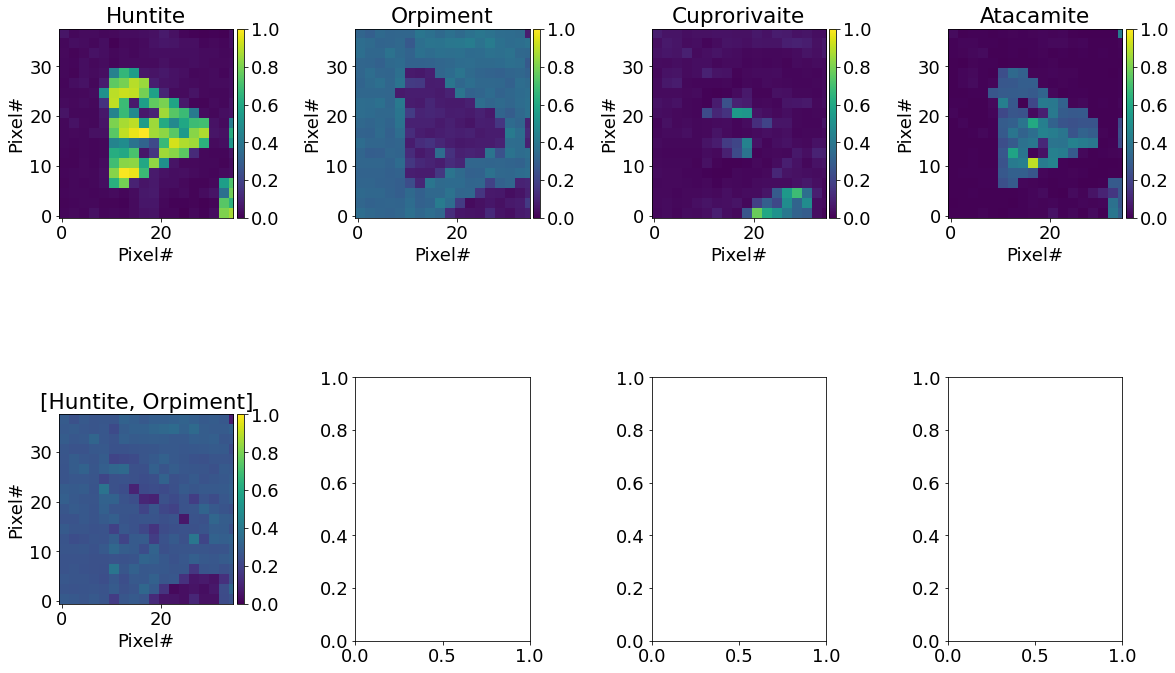

In [69]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

set_nan_as_0 = True

###

n_of_pictures = len(gm1.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 5 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 4)
for i, phase in enumerate(gm1.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]

    matrix_plot = phase_presence_1[..., i] / nanmax(phase_presence_1)
    #matrix_plot = phase_presence_1[..., i] / nanmax(phase_presence_1[..., i])
    if set_nan_as_0:
        matrix_plot[isnan(matrix_plot)] = 0
    im = ax.imshow(matrix_plot, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_title(phase.label)
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')

show()

### Secondary phases

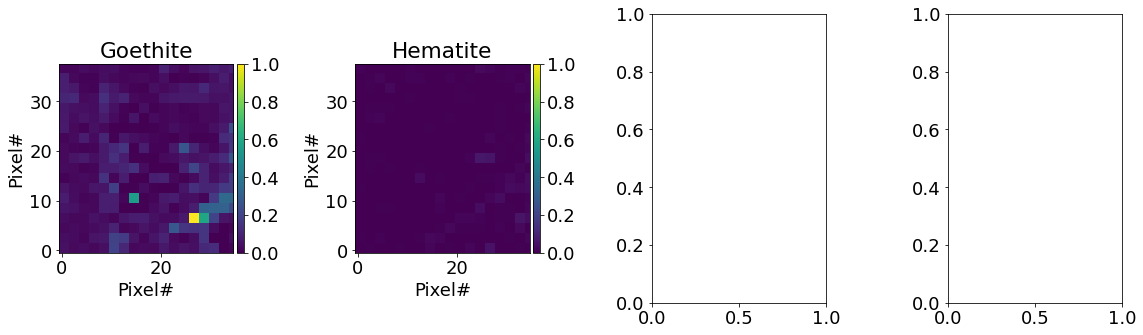

In [70]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

set_nan_as_0 = True

###

n_of_pictures = len(gm2.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 5 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 4)
for i, phase in enumerate(gm2.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]

    matrix_plot = phase_presence_2[..., i] / nanmax(phase_presence_2)
    #matrix_plot = phase_presence_2[..., i] / nanmax(phase_presence_2[..., i])
    if set_nan_as_0:
        matrix_plot[isnan(matrix_plot)] = 0
    im = ax.imshow(matrix_plot, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_title(phase.label)
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')

show()

### Save maps of secondary phases as PNG and TIF

In [71]:
rcParams['font.size'] = 14

for i, phase in enumerate(gm2.phases):
    matrix_plot = phase_presence_2[..., i] / nanmax(phase_presence_2)
    #matrix_plot = phase_presence_2[..., i] / nanmax(phase_presence_2[..., i])
    matrix_plot[isnan(matrix_plot)] = 0
    matrix_tiff = flip((matrix_plot * 65535).astype('uint16'), axis = [0])
    
    fig, ax = subplots(figsize = (5, 3))
    im = imshow(matrix_plot, interpolation = 'none', vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(phase.label)
    fig.set_dpi(80)
    savefig(path_figures + 'secondary - ' + phase.label + ' - presence.png',
                bbox_inches = 'tight', dpi = 600)

    img = Image.fromarray(matrix_tiff)
    img.save(path_results + 'secondary - ' + phase.label + ' - presence BW.tiff')
    img.save(path_figures + 'secondary - ' + phase.label + ' - presence BW.png')

    close(fig)

# Explore phases in a pixel given by element selection

### List of phases

In [72]:
DataFrame({
    'Category': ['Primary'] * len(phases_primary) + ['Secondary'] * len(phases_secondary),
    'Phase': [p.label for p in phases_primary + phases_secondary],
    'Chemical formula': [p['_chemical_formula_sum'] if (type(p) == Phase and '_chemical_formula_sum' in p.keys()) else '-' for p in phases_primary + phases_secondary]
})

,Category,Phase,Chemical formula
0,Primary,Huntite,C4 Ca Mg3 O12
1,Primary,Orpiment,As2 S3
2,Primary,Cuprorivaite,Ca Cu O10 Si4
3,Primary,Atacamite,Cl Cu2 H3 O3
4,Primary,"[Huntite, Orpiment]",-
5,Secondary,Goethite,Fe H O2
6,Secondary,Hematite,Fe2 O3


### Exploration
- The procedure analyses all the phases that have at least one of the elements of `elements_allowed`.
- Also, it selects only pixels where all of `elements_allowed` have an XRF intensity of at least `threshold_min_xrf`.
- The procedure selects the pixel where the first of `elements_allowed` has the maximum XRF intensity. This can be modulated with `quantile_xrf`: when it is set to 1, it means we search the maximum value; for lower values, we search for the given quantile of XRF intensity; when it is set to 0, we search for the minimum value.

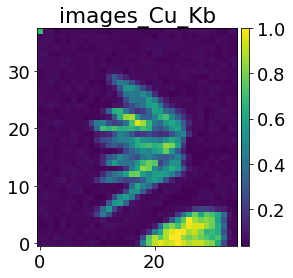

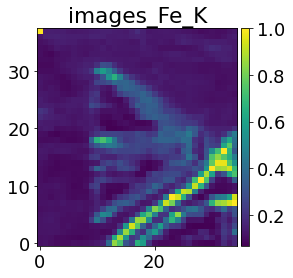

Threshold 0.200 applied as minimum to the following XRF maps: images_Cu_Kb, images_Fe_K.
Selected 167 pixels over 1330.
images_Cu_Kb used to search for 0.900 quantile of XRF intensity.
Chosen coordinates: (21, 22). XRF intensity in the pixel: 0.645


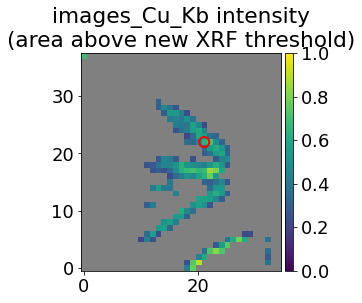

,Category,Phase,Overlap ratio
0,Primary,Cuprorivaite,0.068
1,Primary,Atacamite,0.501
2,Secondary,Goethite,0.004
3,Secondary,Hematite,0.002


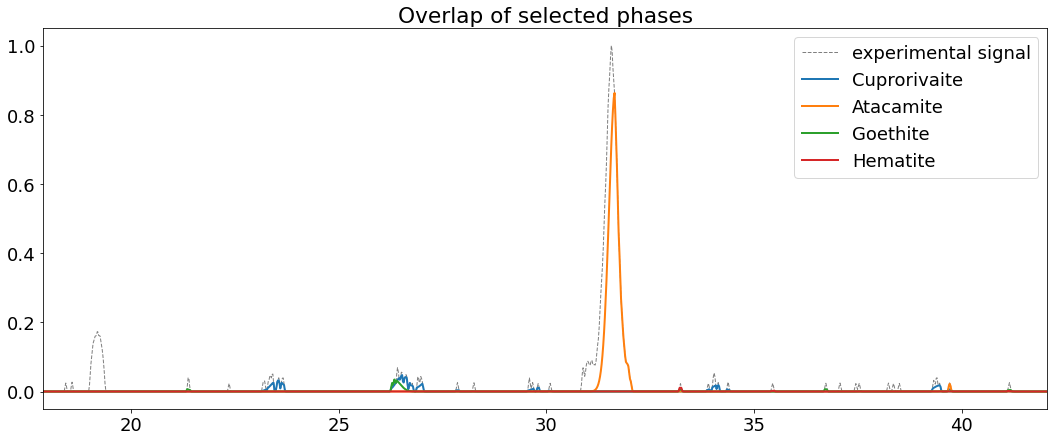

In [73]:
### View options ###
rcParams['font.size'] = 18

### Select phases ###
elements_allowed = ['Cu', 'Fe']   # Select phases that have at least one of the elements
#exclude_phase_names = ['Cinnabar']   # Names of phases that will be excluded from the plot
exclude_phase_names = []   # Leave as empty list to have no excluded phases

### Select pixels ###
threshold_min_xrf = 0.2   # Minimum XRF intensity required to all of elements_allowed
quantile_xrf = 0.9

### Redo the fit ###
redo_fit = False


###

cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')

indices_elements_allowed = []
for e in elements_allowed:
    i = find_element(e, data_xrf_elements.metadata['labels'])
    if i is not None:
        indices_elements_allowed.append(i)
        fig, ax = subplots(figsize = (6, 4))
        im = ax.imshow(maps_xrf_norm[..., i], interpolation = 'none', cmap = cmap_viridis)
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title(data_xrf_elements.metadata['labels'][i])
        show()
    else:
        print("'" + e + "' not found among XRF phases.")

if len(indices_elements_allowed) > 0:

    map_xrf_selected = maps_xrf_norm[..., indices_elements_allowed[0]].copy()

    if (~gm.indices_sel).sum() > 0:
        print(f'The initial selection leaves {gm.n_pixels} pixels.')
        
        map_xrf_selected[~gm.indices_sel] = nan
        
        fig, ax = subplots(figsize = (6, 4))
        im = ax.imshow(map_xrf_selected, vmin = 0, vmax = 1, interpolation = 'none', cmap = cmap_viridis)
        #ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title(data_xrf_elements.metadata['labels'][indices_elements_allowed[0]] + ' intensity\n(initial selection)')
        show()

    print(f'Threshold {threshold_min_xrf:.3f} applied as minimum to the following XRF maps: ' + ', '.join([data_xrf_elements.metadata['labels'][i] for i in indices_elements_allowed]) + '.')
    indices_sel_2 = zeros(data.shape[:2], bool)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if all(maps_xrf_norm[y, x, i] >= threshold_min_xrf for i in indices_elements_allowed):
                indices_sel_2[y, x] = True
    indices_sel_total = gm.indices_sel & indices_sel_2
    map_xrf_selected[~indices_sel_total] = nan
    print(f'Selected {indices_sel_total.sum()} pixels over {gm.n_pixels}.')

    if indices_sel_total.sum() > 0:
        print(f'{data_xrf_elements.metadata["labels"][indices_elements_allowed[0]]} used to search for {quantile_xrf:.3f} quantile of XRF intensity.')
        threshold_qtl_xrf = nanquantile(map_xrf_selected, quantile_xrf)
        map_xrf_qtl = map_xrf_selected.copy()
        map_xrf_qtl[map_xrf_qtl > threshold_qtl_xrf] = nan
        position = nanargmax(map_xrf_qtl.flatten())
        y, x = unravel_index(position, map_xrf_qtl.shape)
        print(f'Chosen coordinates: {(x, y)}. XRF intensity in the pixel: {map_xrf_qtl[y, x]:.3f}')

        fig, ax = subplots(figsize = (6, 4))
        im = ax.imshow(map_xrf_selected, vmin = 0, vmax = 1, interpolation = 'none', cmap = cmap_viridis)
        ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title(data_xrf_elements.metadata['labels'][indices_elements_allowed[0]] + ' intensity\n(area above new XRF threshold)')
        show()

        if redo_fit:
            spectrum_xrd = (
                FastSpectraXRD()
                .from_Data(data_smooth, x, y)
                .remove_background(window_snip = window_snip, offset_background = offset_background)
                .smooth_channels(std_kernel = std_smooth)
            )
            gs1 = GammaSearch(phases_primary, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
            gs1.search()
            gs2 = GammaSearch_Secondary(gs1, phases_secondary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
            gs2 = gs2.fit_cycle(steps = 6, gamma = True)

        else:
            gs2 = gm2.get_pixel(x, y)

        df_overlaps = DataFrame(columns = ['Category', 'Phase', 'Overlap ratio'])
        fig, ax = subplots(figsize = (18, 7))
        theta = gs2.gammasearch_1[0].theta
        ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
        for j, phase in enumerate(phases_primary):
            if '_chemical_formula_sum' in phase:
                if phase.label not in exclude_phase_names:
                    if any(is_element_in_formula(e, phase['_chemical_formula_sum']) for e in elements_allowed):
                        ax.plot(theta, gs2.gammasearch_1.overlap()[j], ls = '-', lw = 2, label = phase.label)
                        df_overlaps.loc[len(df_overlaps)] = ['Primary', phase.label, gs2.gammasearch_1.overlap_area_ratio()[j]]
        for j, phase in enumerate(phases_secondary):
            if '_chemical_formula_sum' in phase:
                if phase.label not in exclude_phase_names:
                    if any(is_element_in_formula(e, phase['_chemical_formula_sum']) for e in elements_allowed):
                        ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = phase.label)
                        df_overlaps.loc[len(df_overlaps)] = ['Secondary', phase.label, gs2.overlap_area_difference_ratio()[j]]

        display(df_overlaps.style.format({'Overlap ratio': '{:.3f}'}))
        ax.legend(frameon = True, loc = 'upper right')
        ax.set_xlim(theta[0], theta[-1])
        ax.set_title('Overlap of selected phases')
        show()

### Overlap of each secondary phases vs all primary phases

Primary phases: 0.829 of experimental area
Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases
Goethite:	0.004
Hematite:	0.002


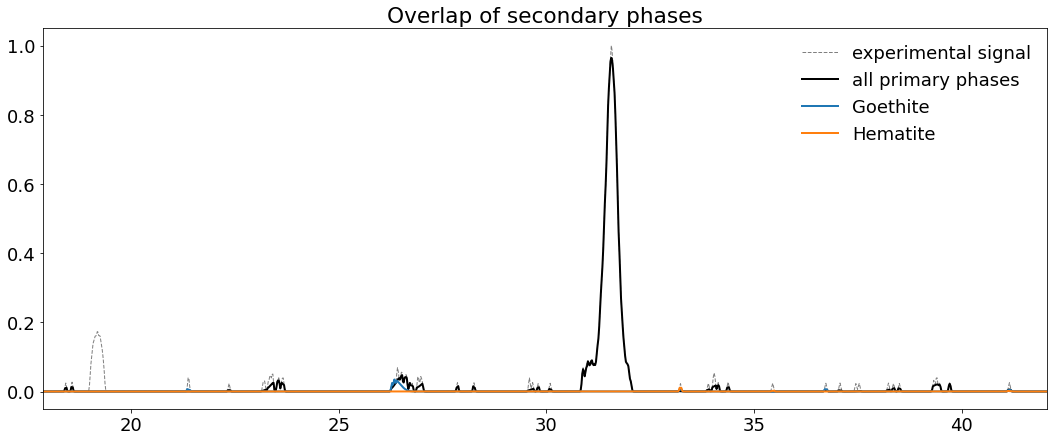

In [74]:
### View options ###

#exclude_phase_names = ['Bone_Black']   # Names of phases that will be excluded from the plot
exclude_phase_names = []   # Leave as empty list to have no excluded phases

###

fig, ax = subplots(figsize = (18, 7))
theta = gs2.gammasearch_1[0].theta
ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
ax.plot(theta, gs2.gammasearch_1.overlap_total(), c = 'black', ls = '-', lw = 2, label = 'all primary phases')
print(f'Primary phases: {gs2.gammasearch_1.overlap_total_ratio():.3f} of experimental area')
print('Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases')
for j in range(len(gs2)):
    if gs2[j].phase.label not in exclude_phase_names:
        ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = gs2[j].phase.label)
        print(f'{gs2[j].label}:\t{gs2.overlap_area_difference_ratio()[j]:.3f}')

legend(frameon = False)
ax.set_xlim(theta[0], theta[-1])
ax.set_title('Overlap of secondary phases')
show()